In [24]:
import pandas as pd
import matplotlib.pyplot as plt

dfConso = pd.read_csv("../data/Table_conso.csv", sep=";", encoding="ansi")
dfIndiv = pd.read_csv("../data/Table_indiv.csv", sep=";", encoding="ansi")
dfCapiCA = pd.read_csv("../data/Table_capi_ca.csv", sep=";", encoding="ansi")
dfCarnetCA = pd.read_csv("../data/Table_carnet_ca_1.csv", sep=";", encoding="ansi")
dfIndivCA = pd.read_csv("../data/Table_indiv_ca.csv", sep=";", encoding="ansi")
dfIndnut = pd.read_csv("../data/Table_indnut.csv", sep=";", encoding="ansi")
dfMenage = pd.read_csv("../data/Table_menage_1.csv", sep=";", encoding="ansi")
dfRepas = pd.read_csv("../data/Table_repas.csv", sep=";", encoding="ansi")
dfNomenclature = pd.read_csv("../data/Nomenclature_3.csv", sep=";", encoding="ansi")
dfCorrespondance = pd.read_csv("../data/correspondance_reponses.csv", sep=";", encoding="ansi")
dfDataNames = pd.read_csv("../data/Data_names_all.csv", sep=";", encoding="ansi")
dfCorrespondance.describe()

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (150,151,152,153,154,155) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,code
count,1105.000000
mean,19.150226
std,36.486908
min,0.000000
25%,2.000000
50%,5.000000
75%,11.000000
max,173.000000


Table_capi_ca.csv
Table_carnet_ca_1.csv
Table_conso.csv
Table_indiv.csv
Table_indiv_ca.csv
Table_indnut.csv
Table_menage_1.csv
Table_repas.csv
correspondance_reponses.csv

In [25]:
marqCounts = dfConso\
    .groupby("libmarq")\
    .agg({"codal": "count"}, as_index=False)\
    .rename(columns={"codal": "count"})\
    .sort_values("count", ascending=False)
marqCounts

,count
libmarq,
x,305523
carrefour,8077
cristaline,6537
leader price,6528
auchan,6344
u,4622
champion,3530
coca cola,3453
dia,3297


In [26]:
print("Brands with more than one item: {} / {}".format(len(marqCounts[marqCounts["count"] > 1]), len(marqCounts)))

Brands with more than one item: 3885 / 7234


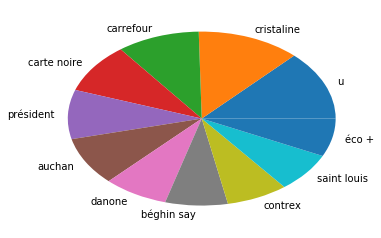

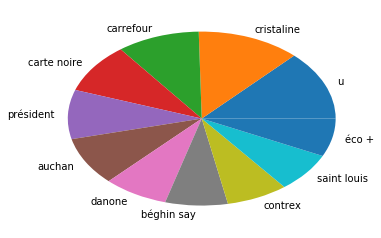

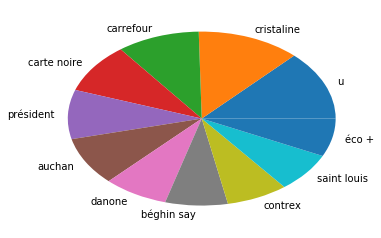

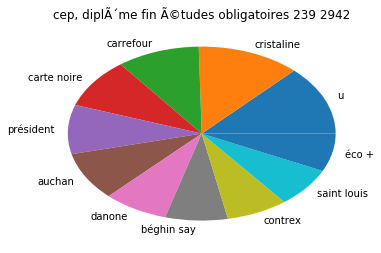

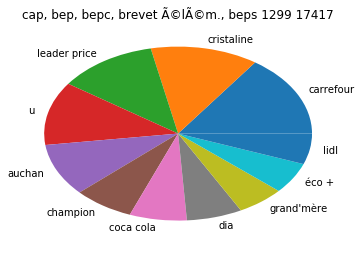

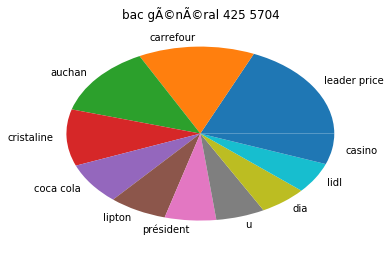

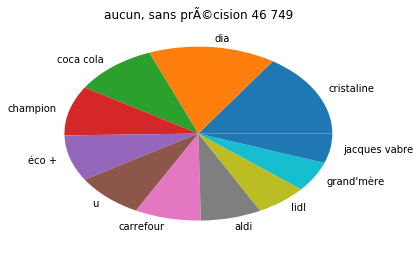

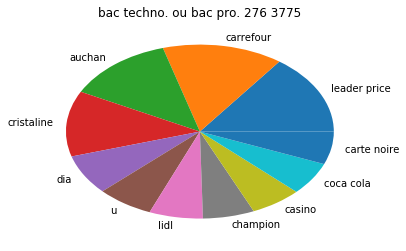

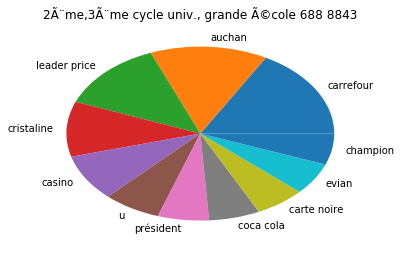

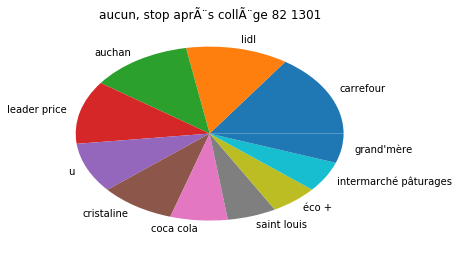

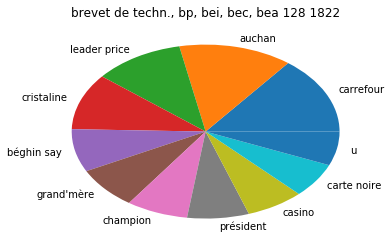

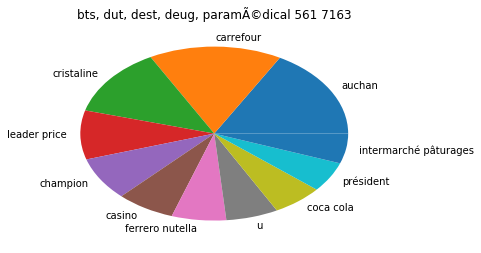

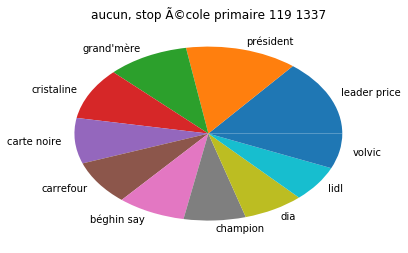

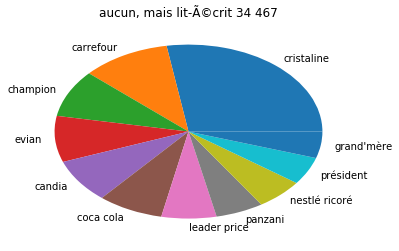

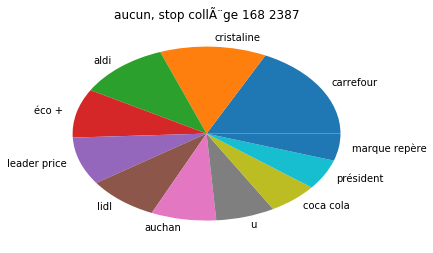

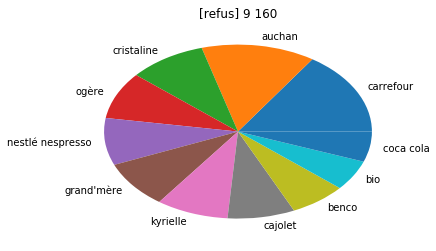

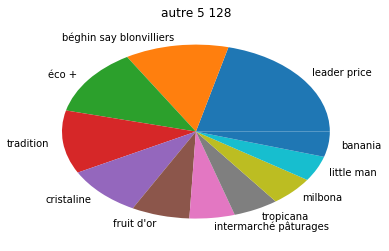

In [60]:
df = dfIndiv.merge(dfConso, left_on="nomen", right_on="nomen", how="inner")
dfBrands = df.groupby(["dip", "libmarq"], as_index=False).agg({"codal": "count"}).rename(columns={"codal": "count"})
dfBrands = dfBrands[dfBrands["count"] > 3]

diplomes = df["dip"].unique()

for diplome in diplomes:
    fig, ax = plt.subplots()
    dfBrandsDiplomes = dfBrands[dfBrands.dip == diplome].sort_values("count", ascending=False)
    ax.pie(x = dfBrandsDiplomes["count"][1:12], labels = dfBrandsDiplomes.libmarq[1:12])
    ax.set_title(dfCorrespondance[(dfCorrespondance["Libellé de codage"] == "diplome") & (dfCorrespondance["code"] == diplome)].Signification.values[0] + " " + str(dfIndiv[dfIndiv["dip"] == diplome].shape[0])+ " " + str(dfBrandsDiplomes["count"][1:12].sum()))
plt.show()

In [58]:
#dfCorrespondance.head(5)
dfCorrespondance[(dfCorrespondance["Libellé de codage"] == "diplome") & (dfCorrespondance["code"] == diplome)].Signification.values[0]
print(dfIndiv[dfIndiv["dip"] == diplome].shape[0])

239
